## Rerun MSA vs. PSP machine learning with Ratios data, No UPDRS

From request [Rerun MSA vs. PSP machine learning with Ratios](https://trello.com/c/Re5D8O5Z)

Use the new data sheet [1002_Data_no_Subj_Site_Ratio.xlsx](1002_Data_no_Subj_Site_Ratio.xlsx)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_data = _data.drop(['UPDRS'], axis=1)
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'classifier__C': 4.281332398719396e-05}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.28      1.00      0.43        55
         1.0       1.00      0.01      0.03       146

   micro avg       0.28      0.28      0.28       201
   macro avg       0.64      0.51      0.23       201
weighted avg       0.80      0.28      0.14       201


Confusion matrix, without normalization
[[ 55   0]
 [144   2]]

recall	0.0136986301369863
precision	1.0
auc	0.5068493150684932
specificity	1.0
npv	0.27638190954773867
accuracy	0.2835820895522388
weighted_sensitivity	0.0136986301369863
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.503448275862069
weighted_accuracy	0.5068493150684932


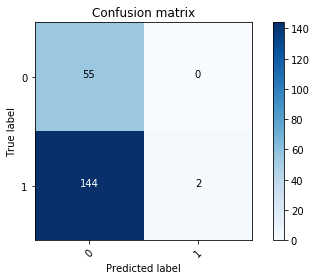

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbri_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbri_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbri_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbri_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars


fit_time	0.23999991416931152	0.011815130699482222
score_time	0.14360513687133789	0.037747114449803575
test_recall	0.8757571214392804	0.21451811479201632
train_recall	0.8961347507783792	0.17201462629746267
test_precision	0.7270333297539853	0.009082756495927645
train_precision	0.7311807192390577	0.01879504669658145
test_auc	0.5069694698105494	0.01226668930649126
train_auc	0.512630177473177	0.0240915740508546
test_specificity	0.13818181818181818	0.23357799058547965
train_specificity	0.1291256041679744	0.22009718952643595
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.6706277588968319	0.09002971265320238
train_accuracy	0.6825545171339564	0.06287528195504109
test_weighted_sensitivity	0.8757571214392804	0.21451811479201632
train_weighted_sensitivity	0.8961347507783792	0.17201462629746267
test_weighted_ppv	0.5069074692949783	0.011742011488067113
train_weighted_ppv	0.5125698078974777	0.024513233613476102
test_weighted_specificity	0.13818181818181818	0.23357799058547965
train_weighted_speci

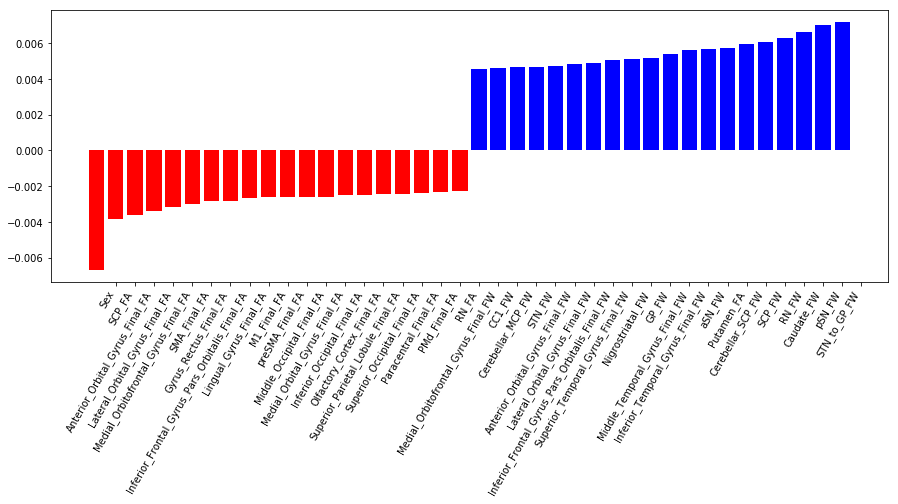

Age	0.002427445524048694
Sex	-0.006660849337688271
aSN_FA	0.0022947921769967488
Caudate_FA	-0.00047753938193859563
CC2_FA	0.0006005752841103036
GP_FA	0.0013906125531995984
LobuleVI_FA	-0.0021835172958715545
LobuleV_FA	-0.002181498835595135
MCP_FA	-0.0008549002753401611
pSN_FA	0.004468076638332177
Putamen_FA	0.005718714639443145
SCP_FA	-0.00384322187487559
STN_FA	0.0028751575103735895
Thalamus_FA	0.004499677925255587
Vermis_FA	0.0012644122176473816
RN_FA	-0.0022944025949509827
PPN_FA	0.0036717492195926737
Dentate_FA	-0.0008004142928927312
CC1_FA	-0.0012434677806490706
aSN_FW	0.005654873518684128
Caudate_FW	0.006638903627405367
CC2_FW	0.003867318727830548
GP_FW	0.0051679459678304965
LobuleVI_FW	0.002631842644208699
LobuleV_FW	0.0038978800752427763
MCP_FW	0.003623854001148213
pSN_FW	0.007020828910032025
Putamen_FW	0.0037263430018586612
SCP_FW	0.006077961721701548
STN_FW	0.00469505983752156
Thalamus_FW	0.0037264394502894422
Vermis_FW	0.0009207161273418463
RN_FW	0.006282328292297184
PPN_FW	

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.28      1.00      0.43        55
         1.0       1.00      0.01      0.03       146

   micro avg       0.28      0.28      0.28       201
   macro avg       0.64      0.51      0.23       201
weighted avg       0.80      0.28      0.14       201



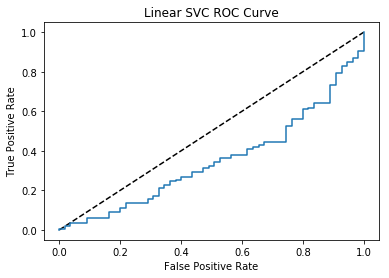

0.0 0.0
0.0 0.00684931506849315
0.01818181818181818 0.00684931506849315
0.01818181818181818 0.02054794520547945
0.03636363636363636 0.02054794520547945
0.03636363636363636 0.03424657534246575
0.09090909090909091 0.03424657534246575
0.09090909090909091 0.06164383561643835
0.16363636363636364 0.06164383561643835
0.16363636363636364 0.08904109589041095
0.2 0.08904109589041095
0.2 0.1095890410958904
0.21818181818181817 0.1095890410958904
0.21818181818181817 0.136986301369863
0.2909090909090909 0.136986301369863
0.2909090909090909 0.15753424657534246
0.3090909090909091 0.15753424657534246
0.3090909090909091 0.17123287671232876
0.32727272727272727 0.17123287671232876
0.32727272727272727 0.21232876712328766
0.34545454545454546 0.21232876712328766
0.34545454545454546 0.22602739726027396
0.36363636363636365 0.22602739726027396
0.36363636363636365 0.2465753424657534
0.38181818181818183 0.2465753424657534
0.38181818181818183 0.2534246575342466
0.4 0.2534246575342466
0.4 0.2671232876712329
0.43636

In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       105
         1.0       0.78      0.90      0.84        40

   micro avg       0.90      0.90      0.90       145
   macro avg       0.87      0.90      0.88       145
weighted avg       0.91      0.90      0.91       145


Confusion matrix, without normalization
[[95 10]
 [ 4 36]]

recall	0.9
precision	0.782608695652174
auc	0.9023809523809523
specificity	0.9047619047619048
npv	0.9595959595959596
accuracy	0.903448275862069
weighted_sensitivity	0.9
weighted_ppv	0.9043062200956938
weighted_specificity	0.9047619047619048
weighted_npv	0.9004739336492891
weighted_accuracy	0.9023809523809524


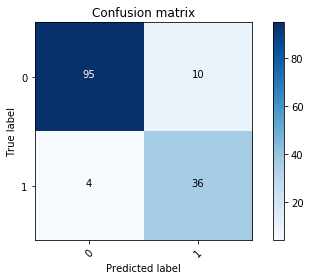

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.06960382461547851	0.004026083099210887
score_time	0.04159445762634277	0.0025723108532090437
test_recall	0.7805042016806724	0.03882825828815875
train_recall	0.861297049317068	0.01449082572844585
test_precision	0.8201469217696399	0.06961117510370342
train_precision	0.8734337600057984	0.029175664787445436
test_auc	0.8520858858448527	0.020164364583725742
train_auc	0.9038631495398256	0.011331871648768692
test_specificity	0.9236675700090334	0.035209757283975046
train_specificity	0.946429249762583	0.013840014166940626
test_npv	0.9083281770329495	0.014442097594614267
train_npv	0.941214960361932	0.006192469470965108
test_accuracy	0.8808657209856611	0.022536351465357825
train_accuracy	0.9209855473093723	0.011698231982473767
test_weighted_sensitivity	0.7805042016806724	0.03882825828815875
train_weighted_sensitivity	0.861297049317068	0.01449082572844585
test_weighted_ppv	0.9129364303361049	0.0367460336591692
train_weighted_ppv	0.9415821395843142	0.014458920601188495
test_weighted_specif

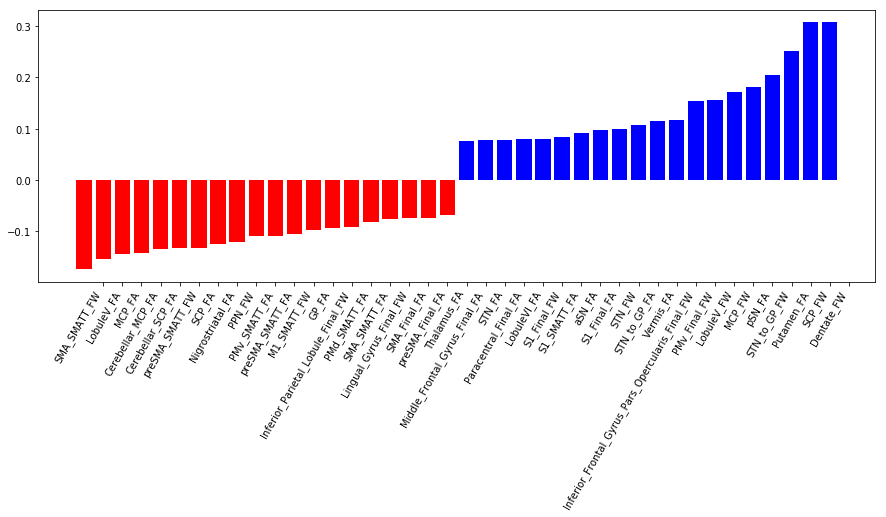

Age	-0.01571283890327651
Sex	0.0
aSN_FA	0.09132244184651404
Caudate_FA	-0.007564112866799492
CC2_FA	0.05640621468997232
GP_FA	-0.09718013836410819
LobuleVI_FA	0.07909047872610658
LobuleV_FA	-0.1534802220052284
MCP_FA	-0.14356802553772555
pSN_FA	0.18055883315470841
Putamen_FA	0.25212479708452507
SCP_FA	-0.13148147062779972
STN_FA	0.07747742186198411
Thalamus_FA	-0.06738737696152877
Vermis_FA	0.11539330570106603
RN_FA	-0.05260947859979096
PPN_FA	0.07624030238978764
Dentate_FA	0.04881120954317084
CC1_FA	-0.0007218622564694692
aSN_FW	0.03007869118441652
Caudate_FW	0.037172493111875225
CC2_FW	-0.030635747695730492
GP_FW	0.05316854734933408
LobuleVI_FW	-0.00891025641701618
LobuleV_FW	0.15542393756396705
MCP_FW	0.17152014632780607
pSN_FW	-0.00016669426886889514
Putamen_FW	0.007426888665582615
SCP_FW	0.3073390011147392
STN_FW	0.09987402133973707
Thalamus_FW	0.033997070805314986
Vermis_FW	0.03620977170387468
RN_FW	-0.03206770157341973
PPN_FW	-0.12065343291491748
Dentate_FW	0.30757014358253504
C

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       105
         1.0       0.78      0.90      0.84        40

   micro avg       0.90      0.90      0.90       145
   macro avg       0.87      0.90      0.88       145
weighted avg       0.91      0.90      0.91       145



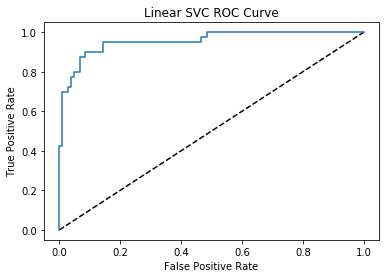

0.0 0.0
0.0 0.025
0.0 0.425
0.009523809523809525 0.425
0.009523809523809525 0.7
0.02857142857142857 0.7
0.02857142857142857 0.725
0.0380952380952381 0.725
0.0380952380952381 0.775
0.047619047619047616 0.775
0.047619047619047616 0.8
0.06666666666666667 0.8
0.06666666666666667 0.875
0.08571428571428572 0.875
0.08571428571428572 0.9
0.14285714285714285 0.9
0.14285714285714285 0.95
0.4666666666666667 0.95
0.4666666666666667 0.975
0.4857142857142857 0.975
0.4857142857142857 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'classifier__C': 0.003359818286283781}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91       131
         1.0       0.34      0.71      0.47        14

   micro avg       0.84      0.84      0.84       145
   macro avg       0.66      0.78      0.69       145
weighted avg       0.91      0.84      0.86       145


Confusion matrix, without normalization
[[112  19]
 [  4  10]]

recall	0.7142857142857143
precision	0.3448275862068966
auc	0.7846237731733915
specificity	0.8549618320610687
npv	0.9655172413793104
accuracy	0.8413793103448276
weighted_sensitivity	0.7142857142857143
weighted_ppv	0.8312182741116751
weighted_specificity	0.8549618320610687
weighted_npv	0.7495219885277247
weighted_accuracy	0.7846237731733915


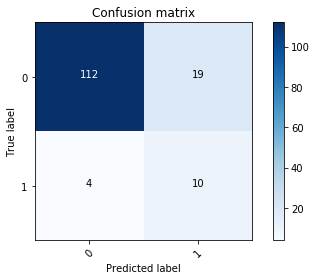

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.09599995613098145	0.003998089500349665
score_time	0.05760040283203125	0.0033818561006483962
test_recall	0.6	0.09689042833036099
train_recall	0.7464285714285714	0.026244532958391204
test_precision	0.49518259518259516	0.0399876940854278
train_precision	0.5727285235006603	0.04062511557222936
test_auc	0.7567656765676568	0.03830182559935315
train_auc	0.8344111108816991	0.011269489692801954
test_specificity	0.9135313531353135	0.02362947112459473
train_specificity	0.9223936503348268	0.013527964110071764
test_npv	0.9436389450919476	0.011718897559622651
train_npv	0.9636047121668516	0.003399446121329686
test_accuracy	0.8756521739130434	0.011639185774222049
train_accuracy	0.9011218068071797	0.01062330712631363
test_weighted_sensitivity	0.6	0.09689042833036099
train_weighted_sensitivity	0.7464285714285714	0.026244532958391204
test_weighted_ppv	0.8759753795434502	0.017402360042790645
train_weighted_ppv	0.9061871799120444	0.013749463287498317
test_weighted_specificity	0.9135313531353135	0

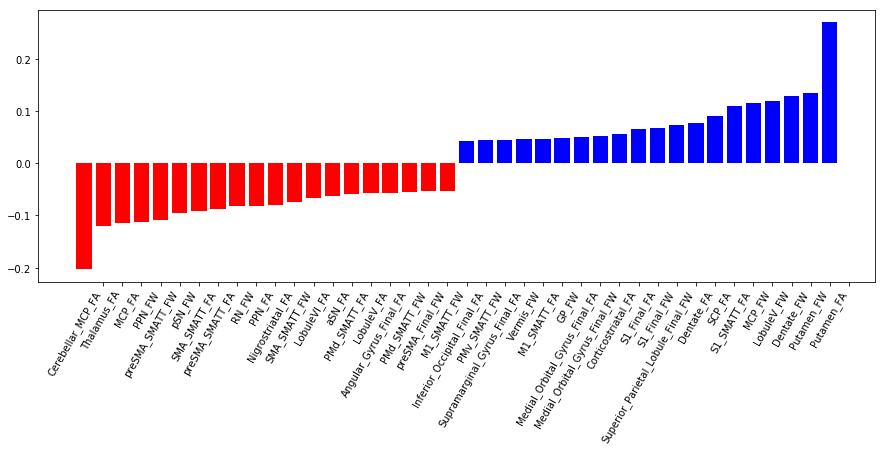

Age	0.013645796670098118
Sex	0.0
aSN_FA	-0.062821257236646
Caudate_FA	-0.025082848458671828
CC2_FA	0.0006442434208625003
GP_FA	0.014179040516347916
LobuleVI_FA	-0.06751709309298866
LobuleV_FA	-0.05747773696822185
MCP_FA	-0.11560377226541588
pSN_FA	-0.0175459217961777
Putamen_FA	0.2698475361691317
SCP_FA	0.09043322775515808
STN_FA	-0.03615712100328555
Thalamus_FA	-0.1201830012476354
Vermis_FA	0.007670286081564115
RN_FA	-0.02469484830461241
PPN_FA	-0.08294243741976304
Dentate_FA	0.07764480348532238
CC1_FA	-0.024550222189130944
aSN_FW	-0.013455301443473655
Caudate_FW	0.016069091471606303
CC2_FW	-0.038215882317683074
GP_FW	0.04884335121042814
LobuleVI_FW	0.009440761541312003
LobuleV_FW	0.11845737889530805
MCP_FW	0.11472939863747056
pSN_FW	-0.09461353132049229
Putamen_FW	0.13346899099915788
SCP_FW	0.018257362612988784
STN_FW	-0.012887962951733518
Thalamus_FW	0.037463968713055684
Vermis_FW	0.04650300050088772
RN_FW	-0.08295825181944355
PPN_FW	-0.11244679853048306
Dentate_FW	0.127454453707702

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91       131
         1.0       0.34      0.71      0.47        14

   micro avg       0.84      0.84      0.84       145
   macro avg       0.66      0.78      0.69       145
weighted avg       0.91      0.84      0.86       145



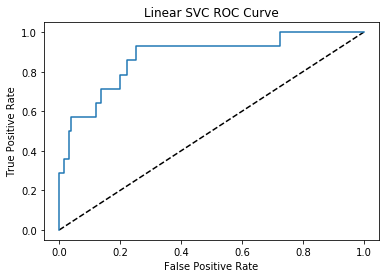

0.0 0.0
0.0 0.07142857142857142
0.0 0.2857142857142857
0.015267175572519083 0.2857142857142857
0.015267175572519083 0.35714285714285715
0.030534351145038167 0.35714285714285715
0.030534351145038167 0.5
0.03816793893129771 0.5
0.03816793893129771 0.5714285714285714
0.12213740458015267 0.5714285714285714
0.12213740458015267 0.6428571428571429
0.13740458015267176 0.6428571428571429
0.13740458015267176 0.7142857142857143
0.1984732824427481 0.7142857142857143
0.1984732824427481 0.7857142857142857
0.22137404580152673 0.7857142857142857
0.22137404580152673 0.8571428571428571
0.25190839694656486 0.8571428571428571
0.25190839694656486 0.9285714285714286
0.7251908396946565 0.9285714285714286
0.7251908396946565 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       119
         1.0       0.78      0.81      0.79        26

   micro avg       0.92      0.92      0.92       145
   macro avg       0.87      0.88      0.87       145
weighted avg       0.93      0.92      0.92       145


Confusion matrix, without normalization
[[113   6]
 [  5  21]]

recall	0.8076923076923077
precision	0.7777777777777778
auc	0.8786360698125404
specificity	0.9495798319327731
npv	0.9576271186440678
accuracy	0.9241379310344827
weighted_sensitivity	0.8076923076923077
weighted_ppv	0.9412429378531073
weighted_specificity	0.9495798319327731
weighted_npv	0.8315878856495896
weighted_accuracy	0.8786360698125404


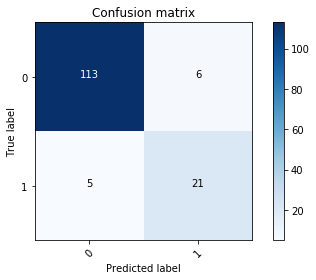

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0568354606628418	0.012308819028284937
score_time	0.03215007781982422	0.0014531788570659849
test_recall	0.8166666666666667	0.053111784737518826
train_recall	0.917513958272113	0.013849928282144788
test_precision	0.8701587301587302	0.07712489176135881
train_precision	0.8939321060259005	0.018104122503061384
test_auc	0.8946820175438596	0.033147827683170886
train_auc	0.9469390484826512	0.007484409803214962
test_specificity	0.9726973684210526	0.01708754142707959
train_specificity	0.9763641386931898	0.004400250622972661
test_npv	0.9605826790835705	0.012061455381179741
train_npv	0.9820463638642043	0.0030227910500384226
test_accuracy	0.944810799728341	0.022126812538540715
train_accuracy	0.9658895568694854	0.004609398627744823
test_weighted_sensitivity	0.8166666666666667	0.053111784737518826
train_weighted_sensitivity	0.917513958272113	0.013849928282144788
test_weighted_ppv	0.9671013947831828	0.02074204017209801
train_weighted_ppv	0.9748948117948245	0.004590064510697021
test_weighted_s

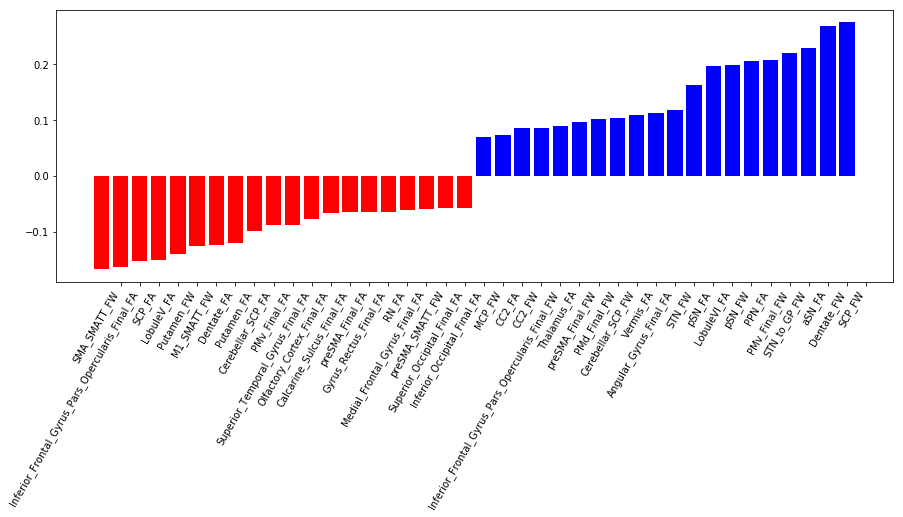

Age	0.04849975365383176
Sex	0.0
aSN_FA	0.2270833245319169
Caudate_FA	-0.000742907185125517
CC2_FA	0.07239680348421403
GP_FA	-0.05070196987643766
LobuleVI_FA	0.19500076403773678
LobuleV_FA	-0.15016775317143233
MCP_FA	0.04281439108404021
pSN_FA	0.16117092416919904
Putamen_FA	-0.12005972198994065
SCP_FA	-0.15189872847325003
STN_FA	0.0557009020011647
Thalamus_FA	0.08921213381052527
Vermis_FA	0.1088049533902218
RN_FA	-0.06475995261724823
PPN_FA	0.2047686717315146
Dentate_FA	-0.12431879745602928
CC1_FA	0.02059699101607589
aSN_FW	0.03413636130488546
Caudate_FW	0.024439683642534286
CC2_FW	0.08464338838671893
GP_FW	-0.05600741728442394
LobuleVI_FW	-0.033590756089562746
LobuleV_FW	-0.01902130436791511
MCP_FW	0.06869424967705698
pSN_FW	0.19694370554322793
Putamen_FW	-0.14062773879966048
SCP_FW	0.27414236151400384
STN_FW	0.11784706163964415
Thalamus_FW	0.028837580261975262
Vermis_FW	0.005002468389611343
RN_FW	0.028022515131524036
PPN_FW	0.020051564514666453
Dentate_FW	0.26771294245999594
CC1_FW	0.

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       119
         1.0       0.78      0.81      0.79        26

   micro avg       0.92      0.92      0.92       145
   macro avg       0.87      0.88      0.87       145
weighted avg       0.93      0.92      0.92       145



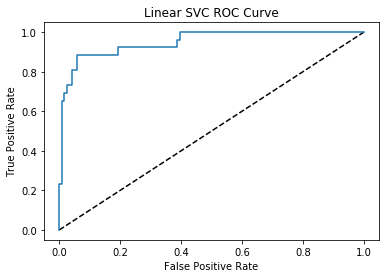

0.0 0.0
0.0 0.038461538461538464
0.0 0.23076923076923078
0.008403361344537815 0.23076923076923078
0.008403361344537815 0.6538461538461539
0.01680672268907563 0.6538461538461539
0.01680672268907563 0.6923076923076923
0.025210084033613446 0.6923076923076923
0.025210084033613446 0.7307692307692307
0.04201680672268908 0.7307692307692307
0.04201680672268908 0.8076923076923077
0.058823529411764705 0.8076923076923077
0.058823529411764705 0.8846153846153846
0.19327731092436976 0.8846153846153846
0.19327731092436976 0.9230769230769231
0.3865546218487395 0.9230769230769231
0.3865546218487395 0.9615384615384616
0.3949579831932773 0.9615384615384616
0.3949579831932773 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74        13
         1.0       0.90      0.87      0.88        30

   micro avg       0.84      0.84      0.84        43
   macro avg       0.81      0.82      0.81        43
weighted avg       0.84      0.84      0.84        43


Confusion matrix, without normalization
[[10  3]
 [ 4 26]]

recall	0.8666666666666667
precision	0.896551724137931
auc	0.8179487179487179
specificity	0.7692307692307693
npv	0.7142857142857143
accuracy	0.8372093023255814
weighted_sensitivity	0.8666666666666667
weighted_ppv	0.7897196261682242
weighted_specificity	0.7692307692307693
weighted_npv	0.8522727272727273
weighted_accuracy	0.8179487179487179


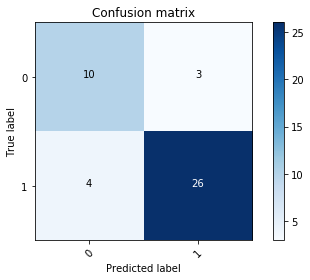

In [19]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [20]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.011597204208374023	0.001357164445559466
score_time	0.02099924087524414	0.008272675413250401
test_recall	0.8389473684210526	0.07265064585735151
train_recall	0.8686392405063291	0.025014096330307784
test_precision	0.8920846233230135	0.047812408046262224
train_precision	0.9636844070961719	0.010547380658949727
test_auc	0.8485213032581453	0.05927017059325673
train_auc	0.911449946067701	0.014771732309839703
test_specificity	0.858095238095238	0.06497164914594493
train_specificity	0.9542606516290727	0.013943038642306898
test_npv	0.7962405731523379	0.08202845481418261
train_npv	0.8397615094424866	0.024652812610508217
test_accuracy	0.8466717596129361	0.06048531324732317
train_accuracy	0.9044314838668639	0.016005000825107196
test_weighted_sensitivity	0.8389473684210526	0.07265064585735151
train_weighted_sensitivity	0.8686392405063291	0.025014096330307784
test_weighted_ppv	0.8564125019577284	0.062278061046801426
train_weighted_ppv	0.9501198353595536	0.014353129152563721
test_weighted_spe

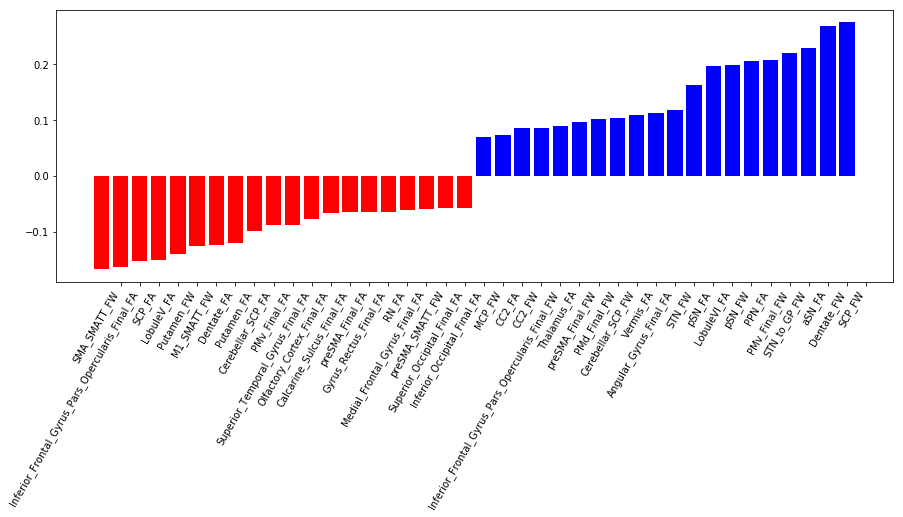

Age	0.04849975365383176
Sex	0.0
aSN_FA	0.2270833245319169
Caudate_FA	-0.000742907185125517
CC2_FA	0.07239680348421403
GP_FA	-0.05070196987643766
LobuleVI_FA	0.19500076403773678
LobuleV_FA	-0.15016775317143233
MCP_FA	0.04281439108404021
pSN_FA	0.16117092416919904
Putamen_FA	-0.12005972198994065
SCP_FA	-0.15189872847325003
STN_FA	0.0557009020011647
Thalamus_FA	0.08921213381052527
Vermis_FA	0.1088049533902218
RN_FA	-0.06475995261724823
PPN_FA	0.2047686717315146
Dentate_FA	-0.12431879745602928
CC1_FA	0.02059699101607589
aSN_FW	0.03413636130488546
Caudate_FW	0.024439683642534286
CC2_FW	0.08464338838671893
GP_FW	-0.05600741728442394
LobuleVI_FW	-0.033590756089562746
LobuleV_FW	-0.01902130436791511
MCP_FW	0.06869424967705698
pSN_FW	0.19694370554322793
Putamen_FW	-0.14062773879966048
SCP_FW	0.27414236151400384
STN_FW	0.11784706163964415
Thalamus_FW	0.028837580261975262
Vermis_FW	0.005002468389611343
RN_FW	0.028022515131524036
PPN_FW	0.020051564514666453
Dentate_FW	0.26771294245999594
CC1_FW	0.

In [21]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74        13
         1.0       0.90      0.87      0.88        30

   micro avg       0.84      0.84      0.84        43
   macro avg       0.81      0.82      0.81        43
weighted avg       0.84      0.84      0.84        43



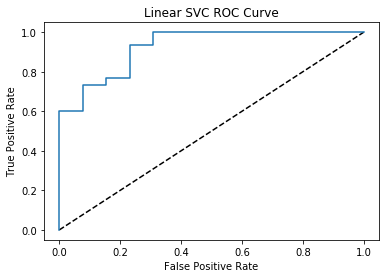

0.0 0.0
0.0 0.03333333333333333
0.0 0.6
0.07692307692307693 0.6
0.07692307692307693 0.7333333333333333
0.15384615384615385 0.7333333333333333
0.15384615384615385 0.7666666666666667
0.23076923076923078 0.7666666666666667
0.23076923076923078 0.9333333333333333
0.3076923076923077 0.9333333333333333
0.3076923076923077 1.0
1.0 1.0


In [22]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88        30
         1.0       0.71      0.77      0.74        13

   micro avg       0.84      0.84      0.84        43
   macro avg       0.81      0.82      0.81        43
weighted avg       0.84      0.84      0.84        43


Confusion matrix, without normalization
[[26  4]
 [ 3 10]]

recall	0.7692307692307693
precision	0.7142857142857143
auc	0.817948717948718
specificity	0.8666666666666667
npv	0.896551724137931
accuracy	0.8372093023255814
weighted_sensitivity	0.7692307692307693
weighted_ppv	0.8522727272727273
weighted_specificity	0.8666666666666667
weighted_npv	0.7897196261682242
weighted_accuracy	0.8179487179487179


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
C:\Users\jtbri_000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


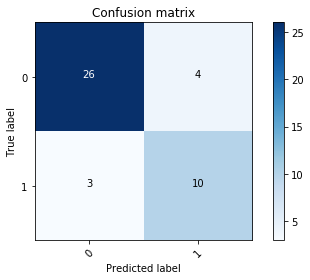

In [23]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.007320690155029297	0.009369855145945691
score_time	0.016575050354003907	0.0013233539877428066
test_recall	0.858095238095238	0.06497164914594493
train_recall	0.9542606516290727	0.013943038642306898
test_precision	0.7962405731523379	0.08202845481418261
train_precision	0.8397615094424866	0.024652812610508217
test_auc	0.8485213032581453	0.059270170593256774
train_auc	0.9114499460677008	0.014771732309839828
test_specificity	0.8389473684210526	0.07265064585735151
train_specificity	0.8686392405063291	0.025014096330307784
test_npv	0.8920846233230135	0.047812408046262224
train_npv	0.9636844070961719	0.010547380658949727
test_accuracy	0.8466717596129361	0.06048531324732317
train_accuracy	0.9044314838668639	0.016005000825107196
test_weighted_sensitivity	0.858095238095238	0.06497164914594493
train_weighted_sensitivity	0.9542606516290727	0.013943038642306898
test_weighted_ppv	0.8441348724712097	0.06412194212018871
train_weighted_ppv	0.8794239290193447	0.020033758925560755
test_weighted_s

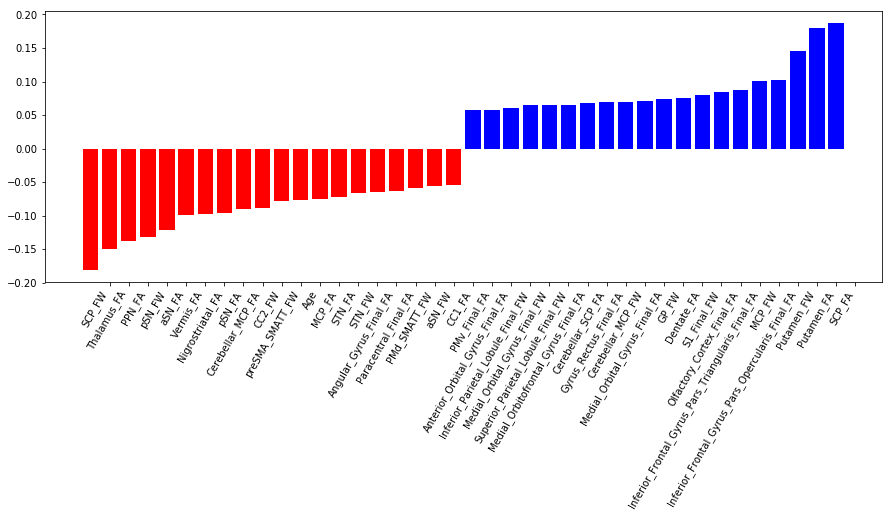

Age	-0.07627117864241661
Sex	-0.028553799301239448
aSN_FA	-0.12153101445203289
Caudate_FA	-0.01409607527369962
CC2_FA	-0.021953006955507483
GP_FA	0.02432163710450392
LobuleVI_FA	-0.05053988311633249
LobuleV_FA	0.0518825434615193
MCP_FA	-0.07501812984341574
pSN_FA	-0.09637815529445075
Putamen_FA	0.18030770867982487
SCP_FA	0.1873740172724766
STN_FA	-0.07169123833116126
Thalamus_FA	-0.15049514605999437
Vermis_FA	-0.0988966840540841
RN_FA	0.01723313973059058
PPN_FA	-0.13833953835519197
Dentate_FA	0.07574873078777203
CC1_FA	-0.05467827761276547
aSN_FW	-0.05654642006373099
Caudate_FW	0.010453547101584271
CC2_FW	-0.08875191514330334
GP_FW	0.07333072695033725
LobuleVI_FW	0.01237098552590014
LobuleV_FW	0.028379001011534868
MCP_FW	0.10057505346997977
pSN_FW	-0.1320042718919029
Putamen_FW	0.14547219721004018
SCP_FW	-0.18117753100470949
STN_FW	-0.06682869938033675
Thalamus_FW	-0.022082208398474423
Vermis_FW	0.006012722490538833
RN_FW	-0.049553201503091414
PPN_FW	-0.044854852888070576
Dentate_FW	0.

In [25]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88        30
         1.0       0.71      0.77      0.74        13

   micro avg       0.84      0.84      0.84        43
   macro avg       0.81      0.82      0.81        43
weighted avg       0.84      0.84      0.84        43



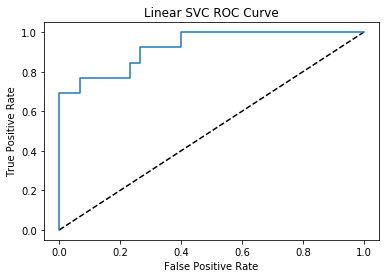

0.0 0.0
0.0 0.07692307692307693
0.0 0.6923076923076923
0.06666666666666667 0.6923076923076923
0.06666666666666667 0.7692307692307693
0.23333333333333334 0.7692307692307693
0.23333333333333334 0.8461538461538461
0.26666666666666666 0.8461538461538461
0.26666666666666666 0.9230769230769231
0.4 0.9230769230769231
0.4 1.0
1.0 1.0


In [26]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)